# Projeto IA 1ªParte

#### THE_3_MUSKETEERS

###### Edith Cardoso - a22007545; Frederico Azevedo - a21900295; Nuno Rasteiro - a21906959;


### Library import


In [11]:
import csv as csv
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
# importado para fazer manhattan distance mas depois usamos a diagonal distance
# from scipy.spatial.distance import cityblock 



#explicar o porque da heuristicas
#Comentario sobre os resultados

### Algoritmo de pesquisa informada num ambiente estático com obstáculos. 

### O objetivo será encontrar o caminho de menor custo desde o nó de partida até ao nó final.


Começamos por criar variaveis globais que vão conter os pesos de cada tipo de etiqueta no mapa.

Estes pesos são-nos dados na seguinte tabela.

<img src= "res/tabelaetiquetas.PNG">


In [12]:
CUSTO_T = 1
CUSTO_A = 3
CUSTO_F_B = 500  # Quando ve F ou B nao considera que é filho do nó

mapa_100x100 = 'sample-environment.csv' # Mudar esta string quando se quiser alterar o ficheiro de 100x100
mapa_15x15 = '15x15.csv'
save = 'final.csv'

Depois criámos uma função para ler o mapa de um csv para um dataframe usando o pandas.


In [13]:
# Importar dados do CSV para
def ler_csv(path):
    df = pd.read_csv(path)
    
    # apagar primeira coluna
    df = df.iloc[:, 1:]
    return df

Agora temos o objetivo de converter este mapa, que temos num dataframe, para um dataset que contenha as ligações possiveis a partir de um nó chave, bem como o seu custo.

Para isso criámos funções que nos ajudam nos passos intermédios dessa conversão.


In [14]:
#Função para obter as cordenadas das etiquetas 'S' e 'E'
def retornar_cordenadas_inicio_fim(mapa):
    """
    Retorna as cordenadas de inicio do jogo e do fim do jogo.

    INPUT:
    dataframe   mapa
    """
    for linha in mapa:
        for coluna in mapa:
            temp_linha = int(linha)
            temp_coluna = int(coluna)
            etiqueta = mapa.loc[temp_linha][temp_coluna]
            
            if (etiqueta in ['S', 'E']):
                if(etiqueta == 'S'):
                    cordenadas_inicio = f'{linha},{coluna}'

                if(etiqueta == 'E'):
                    cordenadas_fim = f'{linha},{coluna}'

    return cordenadas_inicio, cordenadas_fim


In [15]:
#Funções para calcular os custos 
def c(n):
    """
    Dada uma etiqueta 'n' retorna o seu custo
    
    INPUT:
    string   n
    """
    C = {
        'T': CUSTO_T,
        'A': CUSTO_A,
        'S': 0,
        'E': 0,
        'F': CUSTO_F_B,
        'B': CUSTO_F_B,
    }

    return C[n]

In [16]:
# Funcao para calcular as oito direçoes possiveis de andar
def obtem_direcoes_possiveis(linha, coluna):
    """
    A partir de um par linha, coluna (posição atual) retorna uma lista com as oito posições possiveis de se movimentar

    INPUT:
    int         linha
    int         coluna
    """

    direcoes = [f'{max(linha-1,0)},{max(coluna-1,0)}',  # ↖
                f'{max(linha-1,0)},{coluna}',           # ↑
                f'{max(linha-1,0)},{min(coluna+1,99)}', # ↗
                f'{linha},{min(coluna+1,99)}',          # →
                f'{min(linha+1,99)},{min(coluna+1,99)}',# ↘
                f'{min(linha+1,99)},{coluna}',          # ↓
                f'{max(linha-1,0)},{max(coluna-1,0)}',  # ↙
                f'{min(linha+1,99)},{max(coluna-1,0)}', # ←
                f'{linha},{max(coluna-1,0)}']           # ↖

    return direcoes


Depois de termos todas as funções intermediárias podemos então converter o mapa num dataset que servirá de lista de adjacencia.

Para isso fizemos a função abaixo.

In [17]:
# Funcao para criar dataset com os custos
def cria_dataset(mapa):
    """
    Cria um dataset em que a chave é uma posicao do mapa, e os valores são um dicionário do tipo { posição_filho : custo }

    INPUT:
    dataframe   mapa
    """
    df = dict()

    for linha in range(0, len(mapa) - 1):
            for coluna in range(0, len(mapa.columns) - 1):
                    key = f'{linha},{coluna}'
                    etiqueta = mapa.loc[int(linha)][int(coluna)]
                    if etiqueta not in ['B', 'F']:
                        direcoes = obtem_direcoes_possiveis(int(linha), int(coluna))
                        for i in range(len(direcoes)):
                            temp_linha, temp_coluna = direcoes[i].split(',')
                            etiqueta = mapa.loc[int(temp_linha)][int(temp_coluna)] #recebe a etiqueta que está na posição do mapa
                            if etiqueta not in ['B', 'F']:
                                current_key = str(temp_linha) + \
                                    ',' + str(temp_coluna)
                                custo = c(etiqueta)
                                if key not in df:
                                    df[key] = ({current_key: custo})
                                else:
                                    df[key].update({current_key: custo})
    return df


Optamos por usar o algoritmo A* para solucionar este problema.

Para a heuristica optamos por usar a distância diagonal, uma vez que é a mais eficiente e eficaz quando se pode andar em 8 direções.

In [18]:
def h(c1, c2, cf1, cf2, custo_movimento = 2):
    """
    Calcula a heuristica de uma dada posição (c1,c2) até à posição final (cf1, cf2), usando a distância diagonal.
    É usado o custo movimento para optimizar a performance e por ser a média entre o custo da terra e custo da àgua.
    INPUT:
    int         c1
    int         c2
    int         cf1
    int         cf2
    int         custo_movimento
    """

    dx = abs(c1 - cf1)
    dy = abs(c2 - cf2)
    return custo_movimento * (dx + dy) + ((custo_movimento**2) - 2 * custo_movimento) * min(dx, dy)

In [19]:
def meter_nos(visitados,coord1,coord2):
    for coord_x in range(max(int(coord1)-1,0), min(int(coord1)+2, 99)):
        for coord_y in range(max(int(coord2)-1,0), min(int(coord2)+2, 99)):
            visitados.add(f"{coord_x,coord_y}")

In [20]:
def a_star(lista_adj, no_inicial, no_final):
    # open_list é uma lista de todos os nós que foram visitados
    # Nem todos foram inspecionados, começa com o nó inicial.
    # closed_list é uma lista com os nós que já foram visitados.
    # E quem são os vizinhos que foram inspecionados. 
    open_list = set([no_inicial])
    closed_list = set([])
    visitados = set([])
    
    cf1, cf2 = no_final.split(',') # cordenadas do nó de destino

    # g contém distâncias actuais do no_inicial para todos os outros nós.  
    # O valor padrão( se não for encontrado no mapa) é + infinito. 
    g = {}
    g[no_inicial] = 0

    # parents contém um mapa de adjacência de todos os nós 
    parents = {}
    parents[no_inicial] = no_inicial

    while len(open_list) > 0:
        n = None

        # Encontrar o nó com o valor mais baixo de f() - função de avaliação
        for v in open_list:
            cord1, cord2 = v.split(",")
            meter_nos(open_list, cord1,cord2)

            #aux = mapa.loc[int(cord1)][int(cord2)]
            #if n == None or g[v] + cityblock([int(cord1), int(cord2)], [int(cf1), int(cf2)]) < g[n] + cityblock([int(cord1), int(cord2)], [int(cf1), int(cf2)]):
            for coord_x in range(max(int(cord1)-1,0), min(int(cord1)+2)):
                for coord_y in range(max(int(cord2)-1,0), min(int(cord2)+2)):
                    visitados.add(f"{coord_x,coord_y}")

                    
            if n == None or g[v] + h(int(cord1), int(cord2), int(cf1), int(cf2)) < g[n] + h(int(cord1), int(cord2), int(cf1), int(cf2)):
                n = v
                visitados.add(n)
            
        if n == None:
            print('Não existe caminho!')
            return None

        # Se o nó actual estiver na open_list. 
        # Então começamos a reconstruir o caminho a partir do no_inicial.
        if n == no_final:
            reconst_path = []

            while parents[n] != n:
                reconst_path.append(n)
                n = parents[n]

            reconst_path.append(no_inicial)
            reconst_path.reverse()

            return reconst_path, visitados

        # Para todos os vizinhos que o nó actual faz.  
        
        for m in lista_adj[f"{n}"]:
            
                weight = lista_adj[f"{n}"].get(f"{m}")

                # Se o nó actual não estiver na open_list e closed_list. 
                # Adicionar na open_list e observar se n é pai          
                if m not in open_list and m not in closed_list:
                    
                    open_list.add(m)
                    parents[m] = n
                    g[m] = g[n] + weight

                # Caso contrário, verificar se é mais rapido visitar o primeiro n, depois o m. 
                # E se for, então actualiza o parent data e g data.
                # E se o no estiver na closed_list, mova-o para a open_list. 
                else:
                    if g[m] > g[n] + weight:
                        g[m] = g[n] + weight
                        parents[m] = n

                        if m in closed_list:
                            closed_list.remove(m)
                            open_list.add(m)

        # Remover n da open_list , e adicionar na closed_list.
        # Porque todo os seus vizinhos foram inspecionados. 
        open_list.remove(n)
        closed_list.add(n)

    print('Não existe caminho!')
    return None


Depois de obtermos o caminho resultante do A* usamos as seguintes funções para calcular e mostrar os resultados

In [21]:
#Função para calcular o custo do caminho resultante do A*
def calcula_custo_caminho(caminho, mapa):
    """
    Calcula o custo total de um caminho.

    INPUT:
    list        caminho
    dataframe   mapa
    """
    # custo = 0
    # for node in caminho:
    #     cord1, cord2 = node.split(',')
    #     custo += c(mapa.loc[int(cord1)][int(cord2)])
    # return custo
    return sum([(c(mapa.loc[int(node.split(',')[0])][int(node.split(',')[1])])) for node in caminho])

In [22]:
#Função para construir um mapa para ser impresso como heatmap, por questoes de visualização :)
def constroi_mapa_final(mapa, visitados, caminho):
    """
    Constroi o dataframe do mapa final, substitui os nós visitados pela etiqueta 'V' e os nós do menor caminho pela etiqueta 'SP'.

    INPUT:
    dataframe   mapa
    list        visitados
    list        caminho
    """
    mapa_final = mapa.copy(deep=True)
    
    if visitados != None:
        for node in visitados:
            cord1, cord2 = node.split(",")
            mapa_final.loc[int(cord1)][int(cord2)] = 'V'

    for node in caminho:
        cord1, cord2 = node.split(",")
        mapa_final.loc[int(cord1)][int(cord2)] = 'SP'

    return mapa_final

In [23]:
#Função para exportar o mapa resultado para csv
def exporta_df_csv(df, path = save):
    """
    Exporta um dataframe para csv.
    
    INPUT:
    dataframe   df
    """
    df.to_csv(path, encoding='utf-8', index=False)

In [24]:
#Função para gerar o heatmap do mapa
def df_para_heatmap(mapa):
    """
    Converte um dataframe para um heatmap, e imprime-o no ecrã.
    
    INPUT:
    dataframe   mapa
    """
    altera = {
        'SP': 10,
        'V': 6,
        'A': -10,
        'T': 2,
        'S': 0,
        'E': 0,
        'F': 15,
        'B': 15,
        }
    
    aux_mapa = mapa.copy(deep=True)
    aux_mapa = aux_mapa.replace(altera)
    
    sns.heatmap(aux_mapa, square=True, center=0, yticklabels=False, xticklabels=False)
    plt.show()

    

#### Função Principal

In [25]:
class Game():
    def __init__(self):
        self.run_game()

    def run_game(self):
        #Lê o mapa do CSV
        mapa = ler_csv(mapa_100x100)
        print(" == Mapa Inicial ==")
        df_para_heatmap(mapa)
        #Cria uma lista de adjacencia a partir do mapa
        dataset = cria_dataset(mapa)
        #Procura no mapa as coordenadas das etiquetas 'S' e 'E'
        coordenadas = retornar_cordenadas_inicio_fim(mapa)
        #Utiliza o algoritmo A* e guarda o caminho obtido e uma lista com os nós visitados
        caminho, visitados = a_star(dataset,coordenadas[0],coordenadas[1])
        #Calcula o custo a partir do caminho obtido no A*
        custo = calcula_custo_caminho(caminho, mapa)
        #Constroi o mapa final para ser exportado para o CSV
        mapa_final = constroi_mapa_final(mapa, visitados, caminho)
        print(f"Caminho encontrado!\n{caminho}\n\n== Estatísticas ==\nCusto = \033[1;32m{custo}\u001b[0m\nCaminho passa por \033[1;32m{len(caminho)}\u001b[0m nós.\nForam visitados \033[1;32m{len(visitados)}\u001b[0m nós.\n")
        print("== Mapa Final ==\n\033[1;32mLaranja -> Percorrido\nVermelho -> Visitado")
        exporta_df_csv(mapa_final)
        df_para_heatmap(mapa_final)
        df_para_heatmap(constroi_mapa_final(mapa, None, caminho))

 == Mapa Inicial ==


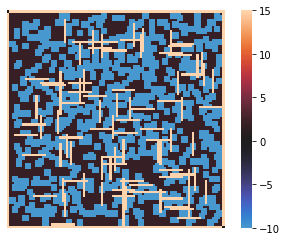

TypeError: 'int' object is not iterable

In [26]:
%%time
def main():
    g = Game()
    


if __name__ == "__main__":
    main()
